In [ ]:
# Import libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [26]:
print("Dataset Info:")
df.info()

print("\nDataset Description (numeric):")
print(df.describe())

print("\nDataset Shape:", df.shape)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se

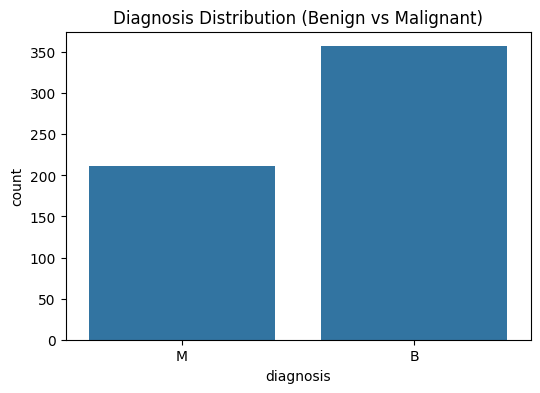

In [27]:
# Initial EDA plots

# Diagnosis distribution countplot
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title('Diagnosis Distribution (Benign vs Malignant)')
plt.show()


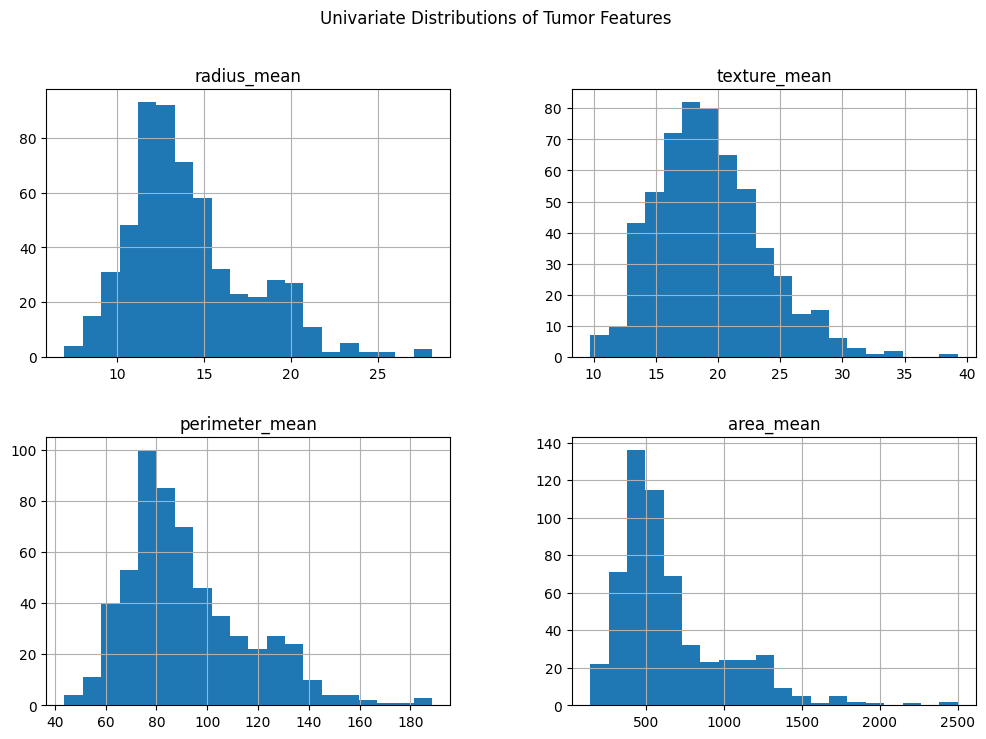

In [28]:
# Histograms of key numeric features
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
df[features].hist(bins=20, figsize=(12,8))
plt.suptitle('Univariate Distributions of Tumor Features')
plt.show()

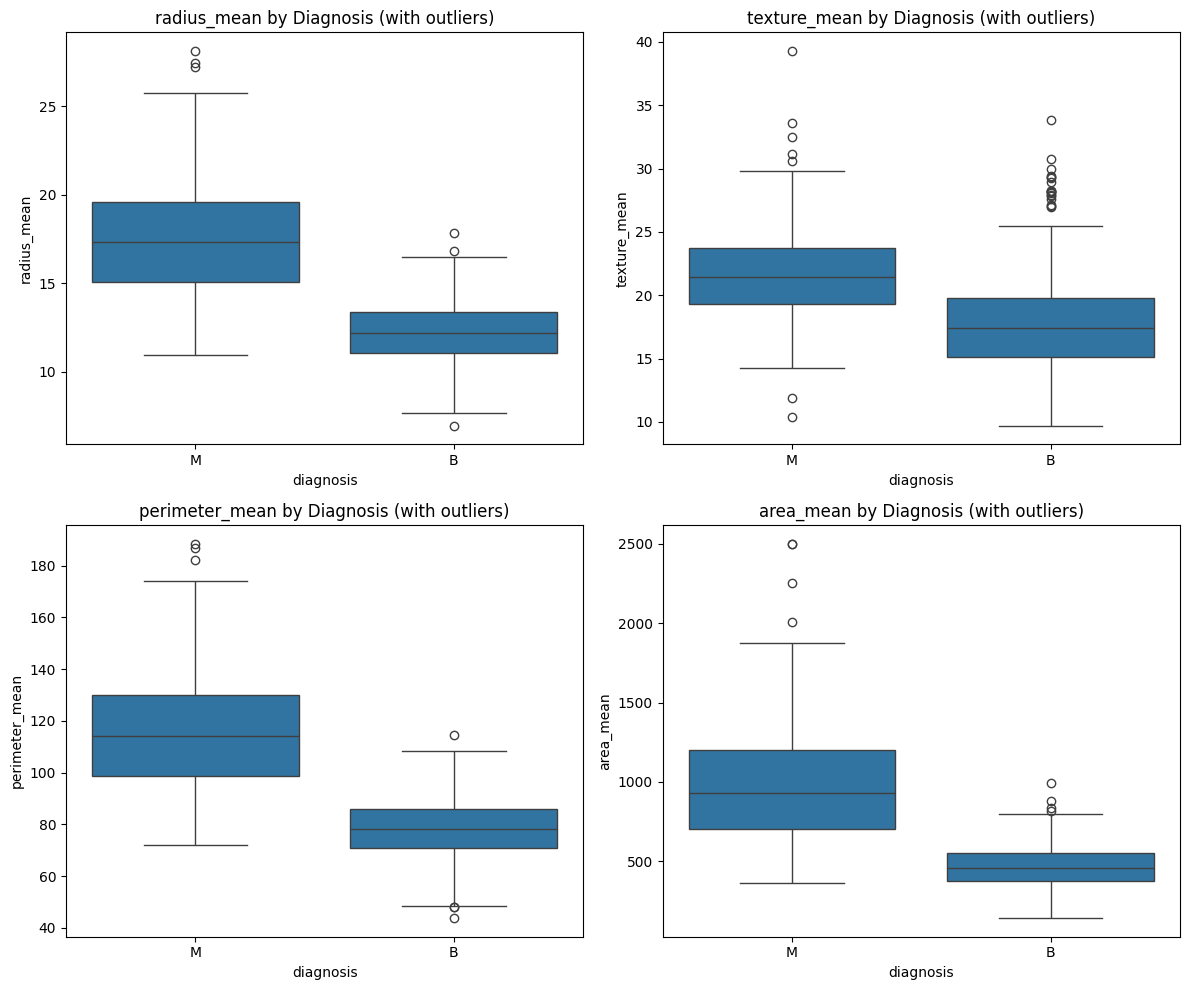

In [ ]:

# Boxplots to detect outliers visually
plt.figure(figsize=(12,10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='diagnosis', y=feature, data=df)
    plt.title(f'{feature} by Diagnosis (with outliers)')
plt.tight_layout()
plt.show()


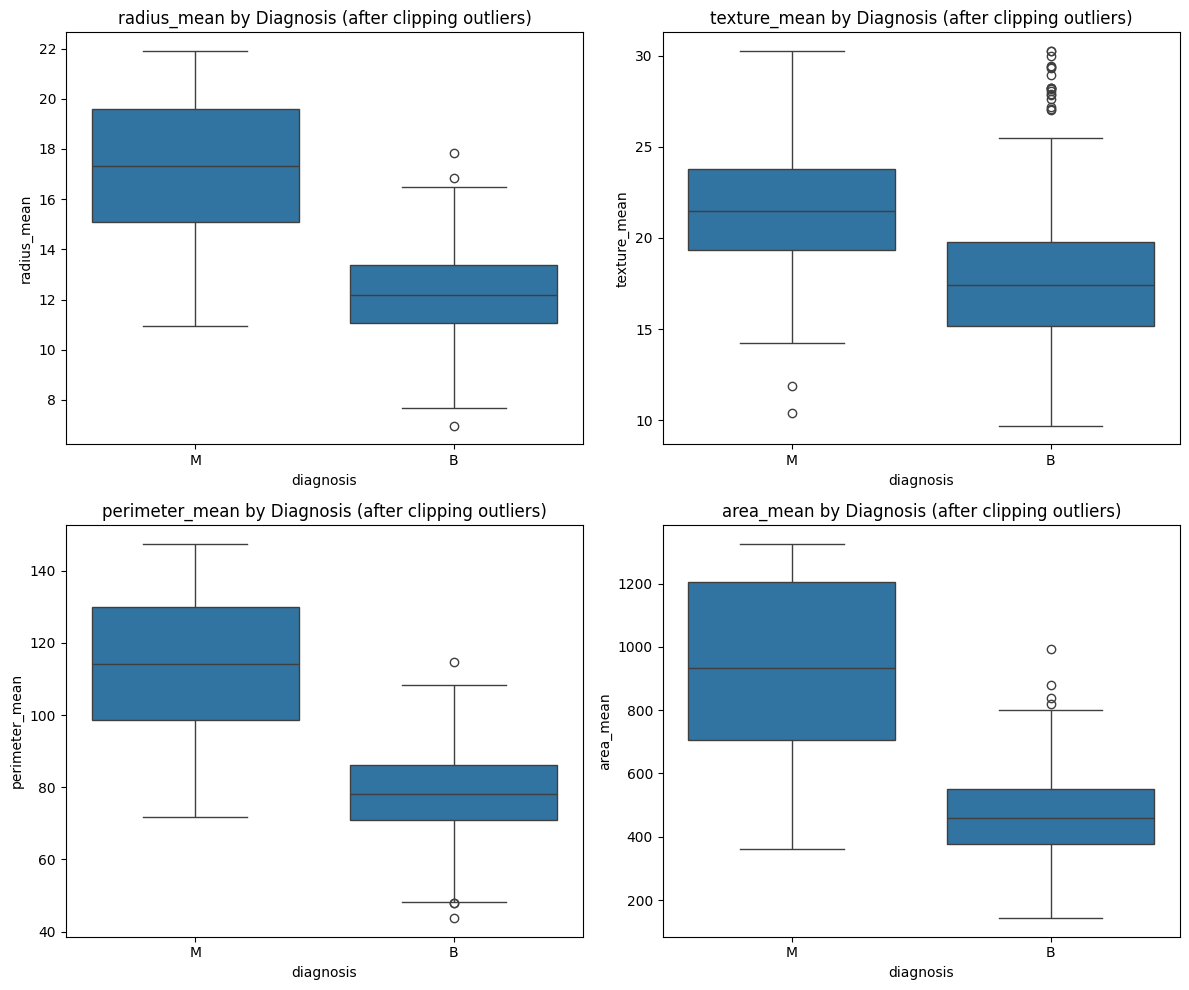

In [32]:
# Cell 4: Clip outliers using IQR

def clip_outliers(df, features):
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
df_clipped = clip_outliers(df.copy(), numeric_features)

# Boxplots after clipping to confirm
plt.figure(figsize=(12,10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='diagnosis', y=feature, data=df_clipped)
    plt.title(f'{feature} by Diagnosis (after clipping outliers)')
plt.tight_layout()
plt.show()


In [33]:
# Cell 5: Fix multicollinearity by dropping highly correlated features (threshold 0.95)

corr_matrix = df_clipped.drop(columns=['id','diagnosis']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Highly correlated features to drop:\n", to_drop)

df_reduced = df_clipped.drop(columns=to_drop)
print("Shape after dropping correlated features:", df_reduced.shape)


Highly correlated features to drop:
 ['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']
Shape after dropping correlated features: (569, 25)


In [ ]:
# Encode target variable

df_reduced['diagnosis'] = df_reduced['diagnosis'].map({'M':1, 'B':0})


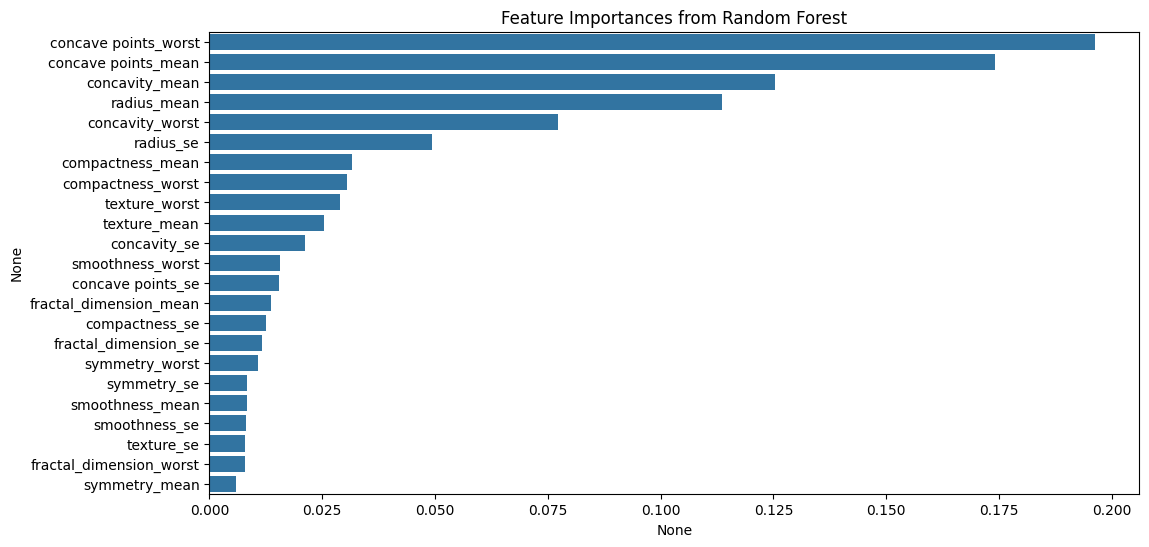

Top features selected: ['concave points_worst', 'concave points_mean', 'concavity_mean', 'radius_mean', 'concavity_worst', 'radius_se', 'compactness_mean', 'compactness_worst', 'texture_worst', 'texture_mean']


In [35]:
#  Feature importance using Random Forest

X = df_reduced.drop(columns=['id', 'diagnosis'])
y = df_reduced['diagnosis']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=importances.index)
plt.title('Feature Importances from Random Forest')
plt.show()

# Select top features (e.g., top 10 for modeling)
top_features = importances.head(10).index.tolist()
print("Top features selected:", top_features)


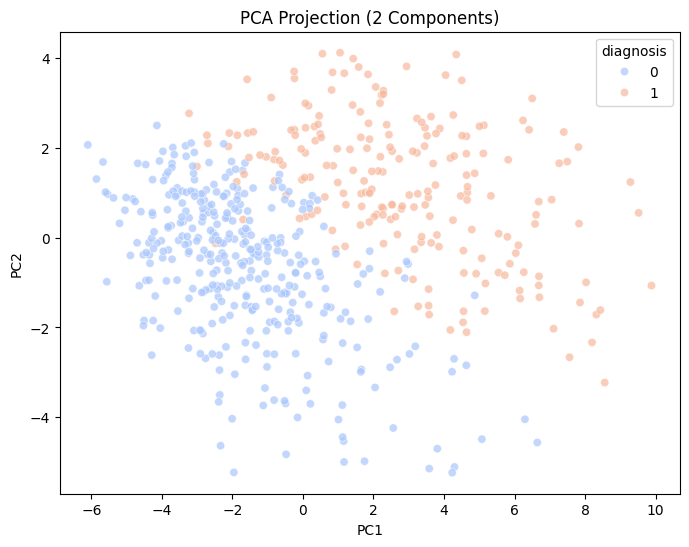

In [36]:
# Optional PCA for dimensionality reduction and visualization

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [37]:
#  Prepare data with selected features/scaling for SVM training

X_selected = df_reduced[top_features]
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_selected, y, test_size=0.2, random_state=42, stratify=y
)


In [38]:
#  Train SVM with linear and RBF kernels and evaluate

# Linear SVM
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)
print("Linear SVM Classification Report")
print(classification_report(y_test, y_pred_linear))

# RBF SVM
rbf_svm = SVC(kernel='rbf', random_state=42)
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print("RBF SVM Classification Report")
print(classification_report(y_test, y_pred_rbf))


Linear SVM Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

RBF SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [39]:
# Hyperparameter tuning for RBF SVM with GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1, 1]}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_rbf = grid_search.best_estimator_
y_pred_best = best_rbf.predict(X_test)

print("Tuned RBF SVM Classification Report")
print(classification_report(y_test, y_pred_best))


Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9582417582417582
Tuned RBF SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [41]:
#  Cross-validation on best tuned model

cv_scores = cross_val_score(best_rbf, X_scaled_selected, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-validation scores: [0.95614035 0.95614035 0.98245614 0.96491228 0.98230088]
Mean CV Accuracy: 0.9683900015525537


In [ ]:
def plot_svm_decision_region(X, y, model, feature_names):
    # Create a mesh grid based on feature range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict for all points in mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contour and training points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette='coolwarm', edgecolor='k')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title('SVM Decision Region')
    plt.show()


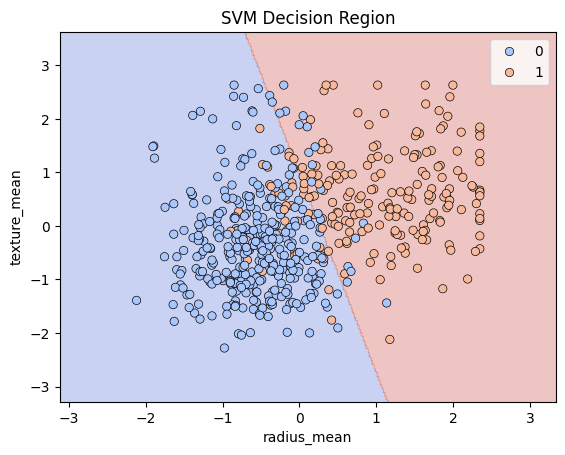

In [ ]:
# Select first two features from scaled data X_scaled for simplicity
X_2d = X_scaled[:, :2]
y_array = y.values  

# Train a new SVM model just on these two features for visualization
svm_2d = SVC(kernel='linear')
svm_2d.fit(X_2d, y_array)

# Call function with data, labels and feature names
plot_svm_decision_region(X_2d, y_array, svm_2d, feature_names=X.columns[:2])
